In [39]:
# import necessary packages
import skimage
from skimage import measure
import pandas as pd
import numpy as np
import os, sys
import argparse
import time
import cv2
import math
import tqdm.notebook as tqdm
import matplotlib
import matplotlib.pyplot as plt
from multiprocessing import Pool
from PIL import Image

sys.path.append('../')

# custom
from utils.GetFileNames import get_file_names

# activate latex text rendering
matplotlib.rcParams['text.usetex'] = True

In [40]:
# load measurements.py
measurements = pd.read_csv('../data/pop_scale/pop_scale_segmentations_measurements/measurements.csv')

# remove all rows with wing area < .2 (outliers)
measurements = measurements[measurements["wing area"] > .2]
measurements.head()

,image_name,seed_count,wing area,env area,seed area
2,pred_862-ref-ISU_002-rep_1-W-CORE_2.png,12,0.986468,0.347347,0.146899
3,pred_862-ref-ISU_002-rep_1-W-CORE_3.png,12,0.953851,0.328243,0.141648
4,pred_862-ref-ISU_002-rep_1-W-CORE_4.png,12,1.013385,0.313852,0.146003
5,pred_862-ref-ISU_002-rep_1-W-CORE_5.png,9,0.931091,0.308906,0.132562
6,pred_862-ref-ISU_002-rep_1-W-CORE_6.png,8,0.851342,0.327508,0.123190


In [41]:
# plot distribution of tissue areas to check for outliers
with plt.style.context('ggplot'):
    plt.hist(measurements["wing area"], bins=100, range=(0, 1.75), label = "wing area", color = "red", alpha = 0.5);
    plt.hist(measurements["env area"], bins=100, range=(0, 1.75), label = "env area", color = "green", alpha = 0.5);
    plt.hist(measurements["seed area"], bins=100, range=(0, 1.75), label = "seed area", color = "blue", alpha = 0.5);
    plt.xlabel("Area (cm^{2})")
    plt.ylabel("Frequency")
    plt.title("Distribution of Areas")
    plt.legend()
    plt.show()

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 640x480 with 1 Axes>

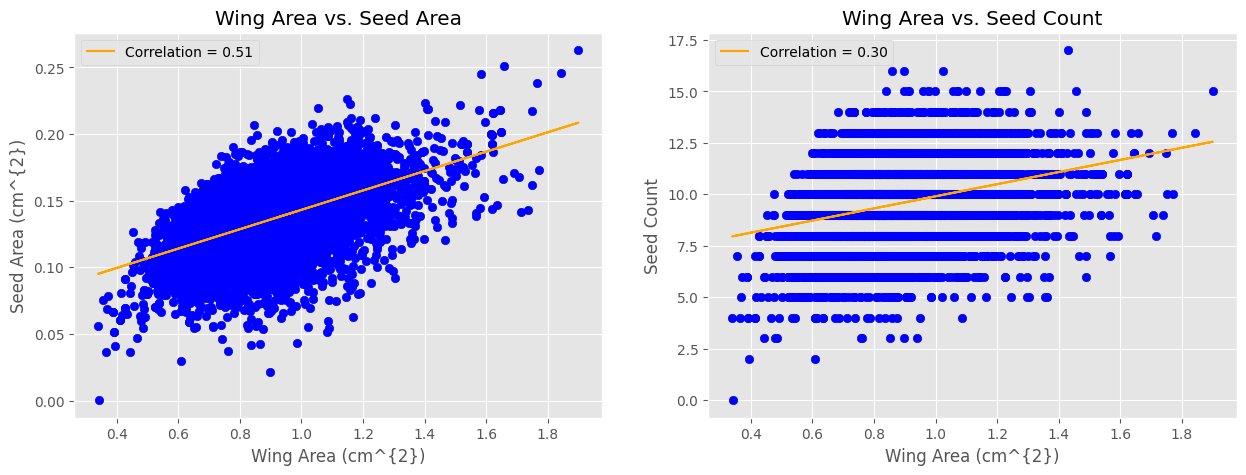

In [35]:
# plot correlations for averages
# get lines of best fit for wing area vs. seed area and seed count
area_slope, area_intercept = np.polyfit(measurements["wing area"], measurements["seed area"], 1)
count_slope, count_intercept = np.polyfit(measurements["wing area"], measurements["seed_count"], 1)

area_pearson = np.corrcoef(measurements["wing area"], measurements["seed area"])[0, 1]
count_pearson = np.corrcoef(measurements["wing area"], measurements["seed_count"])[0, 1]

# plot wing area vs. seed area and seed count
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].scatter(measurements["wing area"], measurements["seed area"], color = "blue")
    ax[0].plot(measurements["wing area"], 
               area_slope * measurements["wing area"] + area_intercept, 
               color = "orange",
               label = f"Correlation = {area_pearson:.2f}")
    ax[0].set_xlabel("Wing Area (cm^{2})")
    ax[0].set_ylabel("Seed Area (cm^{2})")
    ax[0].legend()
    ax[0].set_title("Wing Area vs. Seed Area")

    ax[1].scatter(measurements["wing area"], measurements["seed_count"], color = "blue")
    ax[1].plot(measurements["wing area"], 
               count_slope * measurements["wing area"] + count_intercept, 
               color = "orange",
               label = f"Correlation = {count_pearson:.2f}")
    ax[1].set_xlabel("Wing Area (cm^{2})")
    ax[1].set_ylabel("Seed Count")
    ax[1].legend()
    ax[1].set_title("Wing Area vs. Seed Count")

    plt.show()

In [42]:
# get average areas per genotype
measurements["genotype"] = [name[:-6] for name in measurements["image_name"]]

groupby = measurements.groupby("genotype")
avg_measurements = pd.DataFrame({'avg_wing_area': groupby["wing area"].mean(),
                                 'avg_env_area': groupby["env area"].mean(),
                                 'avg_seed_area': groupby["seed area"].mean(),
                                 'avg_seed_count': groupby["seed_count"].mean(),
                                 'genotype': groupby["genotype"].first()})
avg_measurements.head()

,avg_wing_area,avg_env_area,avg_seed_area,avg_seed_count,genotype
genotype,,,,,
pred_1.tt8t x fc6-1.B.WBP-2022.W,1.035435,0.331851,0.155475,9.2,pred_1.tt8t x fc6-1.B.WBP-2022.W
pred_10.tt8t x fc5-2.B.WBP-2022.W,1.161073,0.400954,0.147018,9.3,pred_10.tt8t x fc5-2.B.WBP-2022.W
pred_100.ISU397_A.B.ISU Wild.S,0.856427,0.280958,0.101233,7.7,pred_100.ISU397_A.B.ISU Wild.S
pred_101.ISU398_A.B.ISU Wild.W,0.623864,0.342791,0.114140,7.5,pred_101.ISU398_A.B.ISU Wild.W
pred_102.ISU399_A.B.ISU Wild.W,0.857869,0.297062,0.119175,8.0,pred_102.ISU399_A.B.ISU Wild.W


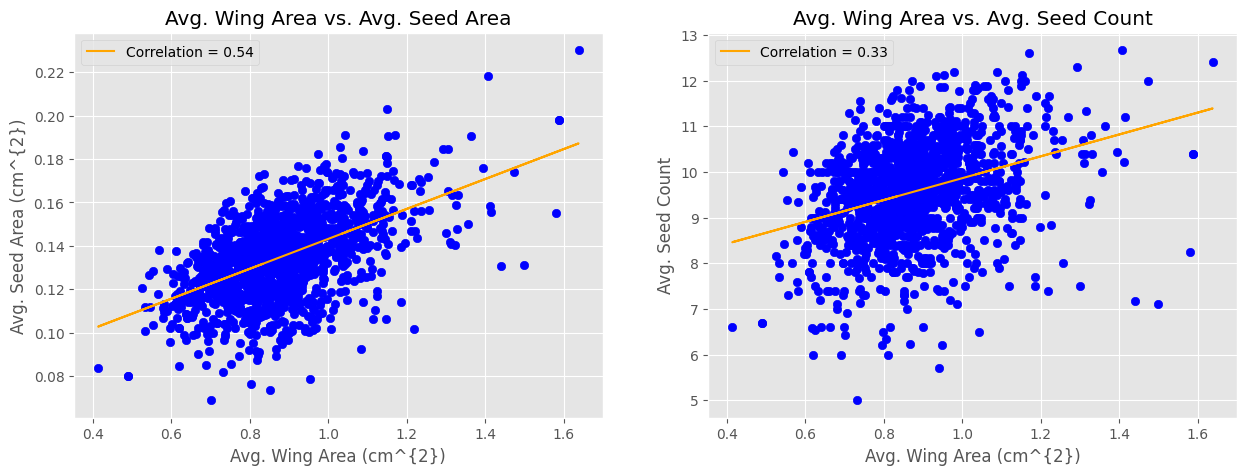

In [34]:
# plot correlations for averages
# get lines of best fit for wing area vs. seed area and seed count
area_slope, area_intercept = np.polyfit(avg_measurements["avg_wing_area"], avg_measurements["avg_seed_area"], 1)
count_slope, count_intercept = np.polyfit(avg_measurements["avg_wing_area"], avg_measurements["avg_seed_count"], 1)

area_pearson = np.corrcoef(avg_measurements["avg_wing_area"], avg_measurements["avg_seed_area"])[0, 1]
count_pearson = np.corrcoef(avg_measurements["avg_wing_area"], avg_measurements["avg_seed_count"])[0, 1]

# plot wing area vs. seed area and seed count
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].scatter(avg_measurements["avg_wing_area"], avg_measurements["avg_seed_area"], color = "blue")
    ax[0].plot(avg_measurements["avg_wing_area"], 
               area_slope * avg_measurements["avg_wing_area"] + area_intercept, 
               color = "orange",
               label = f"Correlation = {area_pearson:.2f}")
    ax[0].set_xlabel("Avg. Wing Area (cm^{2})")
    ax[0].set_ylabel("Avg. Seed Area (cm^{2})")
    ax[0].legend()
    ax[0].set_title("Avg. Wing Area vs. Avg. Seed Area")

    ax[1].scatter(avg_measurements["avg_wing_area"], avg_measurements["avg_seed_count"], color = "blue")
    ax[1].plot(avg_measurements["avg_wing_area"], 
               count_slope * avg_measurements["avg_wing_area"] + count_intercept, 
               color = "orange",
               label = f"Correlation = {count_pearson:.2f}")
    ax[1].set_xlabel("Avg. Wing Area (cm^{2})")
    ax[1].set_ylabel("Avg. Seed Count")
    ax[1].legend()
    ax[1].set_title("Avg. Wing Area vs. Avg. Seed Count")

    plt.show()

In [44]:
# specify input / output directories
img_path = '../data/train/train_images_by_pod/'
seg_path = '../data/train/train_masks_by_pod/'

# Get segmentations filenames
img_names = get_file_names(img_path, '.png')
print('Number of segmentations:', len(img_names))

seg_names = get_file_names(seg_path, '.png')
print('Number of segmentations:', len(seg_names))

FileNotFoundError: [Errno 2] No such file or directory: '../data/pop_scale/pop_scale_images_by_pod/'

In [36]:
img_names[0], seg_names[0]

('25.tt8t x fc5.B.WBP-2023.W_0.png', '25.tt8t x fc5.B.WBP-2023.W_0.png')

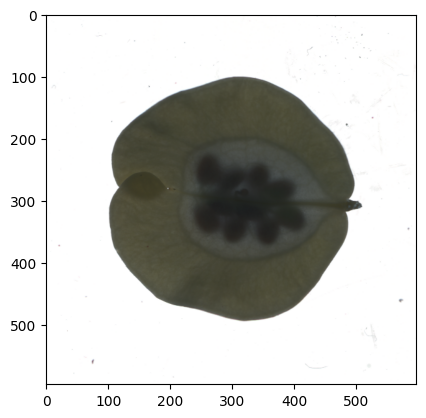

In [37]:
test_image = Image.open(img_path + img_names[0])
test_image = np.array(test_image)

test_mask = np.array(Image.open(seg_path + seg_names[0]))

In [39]:
rgb = test_image
hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
lab = cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)
r, g, b = rgb.astype(float).transpose(2, 0, 1)
h, s, v = hsv.astype(float).transpose(2, 0, 1)
l, a, B = lab.astype(float).transpose(2, 0, 1)

In [40]:
# extract color features for segmentation classes
# concat all feature maps into a tensor, index in with class label mask
features = np.stack([r, g, b, h, s, v, l, a, B], axis=-1)
features.shape

(596, 597, 9)

In [46]:
# separate out the classes
wing = test_mask[:,:,0] > 128
env = test_mask[:,:,1] > 128
seed = test_mask[:,:,2] > 128 

In [49]:
# get features by class
wing_features = features[wing] # output is (n_pixels, n_features)
env_features = features[env]
seed_features = features[seed]

wing_features.shape, env_features.shape, seed_features.shape

((86501, 9), (24642, 9), (10291, 9))

In [51]:
# aggregate features into phenotypes
wing_phenotype = wing_features.mean(axis=0)
wing_phenotype


array([ 76.59266367,  76.66958763,  60.24729194,  31.53321927,
        58.22178934,  77.27232055,  81.80275373, 124.76688131,
       137.84170125])

In [45]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
ax[0].imshow(r, cmap='Reds'); ax[0].set_title('Red')
ax[1].imshow(g, cmap='Greens'); ax[1].set_title('Green')
ax[2].imshow(b, cmap='Blues'); ax[2].set_title('Blue')

NameError: name 'r' is not defined

Error in callback <function _draw_all_if_interactive at 0x7f7f4dcf2b80> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 1500x1500 with 3 Axes>

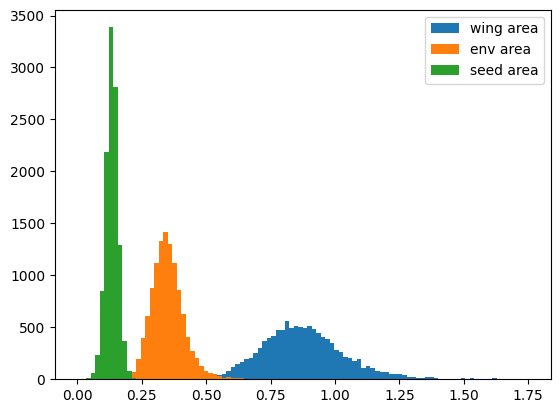

In [64]:
df = pd.read_csv("../data/pop_scale/pop_scale_segmentations_measurements/measurements.csv")
df.head()

# plt.hist(df["wing area"], bins=100);

# remove all rows with wing area < .2
df = df[df["wing area"] > .2]


# add a legend to show the color mapping
